In [3]:
%cd /content/drive/MyDrive/딥러닝2권/2권/03word2vec

/content/drive/MyDrive/딥러닝2권/2권/03word2vec


## 3.2 CBOW(Continuous bag of words)

In [5]:
'''
CBOW의 입력층이 여러 개이면 은닉층은 입력층 출력의 평균으로 계산
입력층의 가중치를 단어의 분산 표현으로
은닉층의 뉴런 개수가 입력층보다 적어야 단어 예측에 필요한 정보를 간결하게 담고, 밀집벡터로 표현 가능
'''

# 간단한 예시
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# input data
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
w_in = np.random.randn(7,3)
w_out = np.random.randn(3,7)

# layers
layer1 = MatMul(w_in)
layer2 = MatMul(w_in)
out_layer = MatMul(w_out)

# propagation
h0 = layer1.forward(c0)
h1 = layer2.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.79996927 -0.71338858  0.14327781  0.24606589 -0.72791627  0.54398013
   0.45457618]]


### 3.3 CBOW 학습데이터 형성

In [6]:
# 맥락과 타겟을 만들어야

from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

context, target = create_contexts_target(corpus, 1)

print(context)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [7]:
# 원핫으로 변환
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

vocab_size = len(word_to_id) # 전체 길이
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(context, vocab_size)

In [11]:
print(target)
print('-----------------------')
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
-----------------------
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW 구현

In [12]:
# window 1개 기준으로 구현

from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        w_in = 0.01 * np.random.randn(V, H).astype('f')
        w_out = 0.01 * np.random.randn(H, V).astype('f')

        # layers
        self.in_layer0 = MatMul(w_in)
        self.in_layer1 = MatMul(w_in)
        self.out_layer = MatMul(w_out)
        self.loss_layer = SoftmaxWithLoss()

        # 가중치, 기울기
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 분산 표현
        self.word_vecs = w_in

    def forward(self, contexts, target): # context는 3차원의 넘파이 배열; 순차적으로 미니배치 수, 윈도우 크기, 원핫 벡터
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = 0.5 * (h0 + h1)
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)

        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5 # h0이랑 h1 계산할 때 순전파에서 0.5 곱해줘서
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)

        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


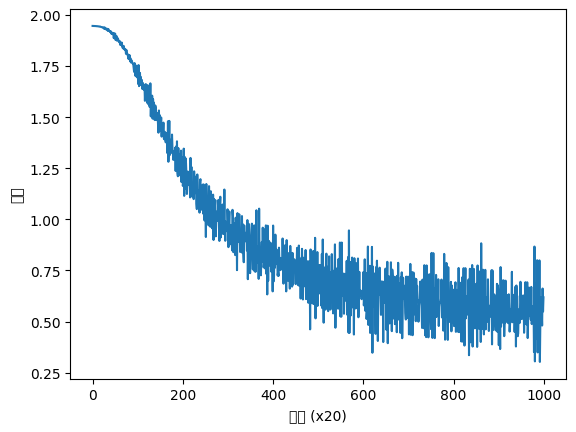

In [14]:
# 학습 코드 구현
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [15]:
# 분산 표현 확인
word_vecs = model.word_vecs

for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.0730315  1.0176347 -1.3611001 -1.0942031 -1.0739542]
say [-0.50440115 -1.2194974  -0.08298786  1.2043624   1.2036954 ]
goodbye [ 0.9576955   0.79004544 -0.55914605 -0.7189076  -0.73322195]
and [-1.551754   -0.8973496  -1.7046552   0.88687223  0.9078491 ]
i [ 0.9431068   0.78055227 -0.55513453 -0.7045336  -0.69527274]
hello [ 1.0862249  1.0204899 -1.3594564 -1.0902785 -1.0624843]
. [ 1.6388191 -1.1574765  1.4396304  1.1822255  1.158162 ]


모델 선언 시 가중치를 난수로 지정해서, 결과값의 차이는 발생

## 3.5 Skip gram 구현

In [16]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # layer
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 분산 표현
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 26 |

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


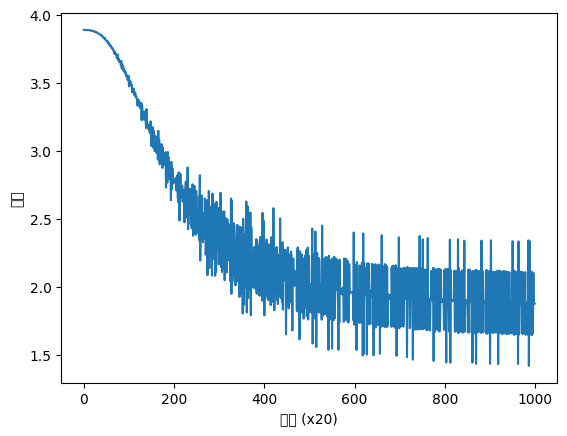

In [18]:
model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size) # CBOW와는 반대로 들어감
trainer.plot()

In [ ]:
## 말뭉치가 너무 적어서 skip-gram의 성능이 cbow보다 낮게 나옴